# Book_RL An Intro by Sutton
## Chapter 5 Monte Carlo Methods

The first learning methods for estimating value functions and discovering optimal policies:
- No complete knowledge of the environment
- Require only *experience* - sample (states, actions, rewards) from actual or simulated interaction

1) Learning from *actual* experience is striking:
- Requires no prior knowledge of the environment's dynamics
- Yet, can still attain optimal behavior

2) Learning from *simulated* experience is also powerful:
- Model is needed, but need only generate sample transitions, not the complete probability distributions of all(required for DP)
- In many cases, easy to generate experience sampled according to the desired probability distributions (when the explicit form is infeasible)

MC methods sample and average returns

In this chapter, only for episodic tasks (complete returns):
- Only on the completion of an episode, value estimates & policied changed
- Thus incremental (episode-by-episode)

Because of nonstationarity, adapt general policy iteration(GPI) where only sample experience is available

Here, we learn value functions from sample returns with the MDP
1. Prediction problem (v<sub>π</sub> and q<sub>π</sub> for a fixed arbitrary π)
2. Policy improvement
3. Control problem by GPI

### 5.1 Monte Carlo Prediction
Simply average returns observed after visits to that state:
- First-visit MC: most widely studied since 1940s
- Every-visit MC: extends to function approximation and eligibility traces (Chapters 9, 12)

In finding **v<sub>π</sub>(s)**,
- Each average is an unbiased estimate
- Standard deviation falls as 1/$\sqrt{n}$

# Blackjack example

Can be formulated as an episodic finite MDP<br>
Infinite deck

200 states = 10 \* 10 \* 2
- Current sum (12~21)
- Dealer's up card (ace~10)
- Whether holding a usable ace

Same state never recurs within one episode

In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# 2017 Nicky van Foreest(vanforeest@gmail.com)                        #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# actions: hit or stick
ACTION_HIT = 0
ACTION_STICK = 1
actions = [ACTION_HIT, ACTION_STICK]

# policy for player
policyPlayer = np.zeros(22, dtype='int')
for i in range(12, 20):
    policyPlayer[i] = ACTION_HIT
policyPlayer[20] = ACTION_STICK
policyPlayer[21] = ACTION_STICK

# policy for dealer
policyDealer = np.zeros(22, dtype='int')
for i in range(12, 17):
    policyDealer[i] = ACTION_HIT
for i in range(17, 22):
    policyDealer[i] = ACTION_STICK

In [3]:
np.column_stack((range(22),
                 policyPlayer, policyDealer))[12:]

array([[12,  0,  0],
       [13,  0,  0],
       [14,  0,  0],
       [15,  0,  0],
       [16,  0,  0],
       [17,  0,  1],
       [18,  0,  1],
       [19,  0,  1],
       [20,  1,  1],
       [21,  1,  1]])

In [4]:
# function form of target policy of player
def targetPolicyPlayer(playerSum, dealerCard, usableAcePlayer):
    return policyPlayer[playerSum]

# function form of behavior policy of player
def behaviorPolicyPlayer(playerSum, dealerCard, usableAcePlayer):
    if np.random.binomial(1, 0.5) == 1:  # num of success of 1 trial with probability 0.5
        return ACTION_STICK
    else:
        return ACTION_HIT

In [5]:
# get a new card
def getCard():
    card_rank = np.random.randint(1, 14)  # 1~13: A, 2, 3, 4, 5, 6, 7, 8, 9, 10, J, Q, K
    card_value = min(card_rank, 10)
    return card_value


def play(policyPlayerFn, init_state=None, init_action=None):
    '''
    play a game
    @policyPlayerFn: specify policy for player
    @init_state: [sum of player's cards,
                  dealer's Up card,
                  whether player has a usable Ace (to use as 1)]
    @init_action: initial action
    '''
    
    # initialize player status
    playerSum = 0  # sum of player
    playerTrajectory = []  # trajectory of player
    usableAcePlayer = False  # whether player uses Ace as 11
    
    # initialize dealer status
    dealerUpCard = 0
    dealerDownCard = 0
    usableAceDealer = False
    
    if init_state is None:  # generate a random initial state
        
        numOfAce = 0
        
        # initialize cards of player
        while playerSum < 12:
            # while sum of player is less than 12, hit (because always beneficial)
            card = getCard()
            
            # if get an Ace, use it as 11
            if card == 1:
                numOfAce += 1
                card = 11
                usableAcePlayer = True
            
            playerSum += card
            
        # if player's sum is larger than 21, it means there must be at least 1 Ace (up to 2 possible)
        if playerSum > 21:
            # use the Ace as 1 rather than 11
            playerSum -= 10
            
            # if the player has only 1 Ace, then no more usable Ace
            if numOfAce == 1:
                usableAcePlayer = False
        
        # initialize cards of dealer
        dealerUpCard = getCard()
        dealerDownCard = getCard()
    
        # initial state of the game
        init_state = [playerSum, dealerUpCard, usableAcePlayer]
    
    else:  # use specified initial state
        playerSum = init_state[0]
        dealerUpCard = init_state[1]
        usableAcePlayer = init_state[2]
        dealerDownCard = getCard()
    
    # initialize dealer's sum
    dealerSum = dealerUpCard + dealerDownCard
    
    if dealerUpCard == 1 or dealerDownCard == 1:
        dealerSum += 10
        usableAceDealer = True
    
    
    ### game starts! ###
    
    # player's turn
    while True:
        if init_action is not None:
            action = init_action
            init_action = None
        
        else:
            # get action based on current state
            action = policyPlayerFn(playerSum, dealerUpCard, usableAcePlayer)
        
        # track player's trajectory for importance sampling
        playerTrajectory.append([action, (playerSum, dealerUpCard, usableAcePlayer)])
        
        if action == ACTION_STICK:
            break
        # if not, hit(get new card)
        playerSum += getCard()
        
        # player busts
        if playerSum > 21:
            # if player has a usable Ace, use it as 1 to avoid busting and continue
            if usableAcePlayer == True:
                playerSum -= 10
                usableAcePlayer = False
            else:
                # otherwise player loses
                return init_state, -1, playerTrajectory
    
    # dealer's turn
    while True:
        action = policyDealer[dealerSum]  # get action based on current sum
        
        if action == ACTION_STICK:
            break
        # if not, hit(get new card)
        dealerSum += getCard()
        
        # dealer busts
        if dealerSum > 21:
            if usableAceDealer == True:
            # if dealer has a usable Ace, use it as 1 to avoid busting and continue
                dealerSum -= 10
                usableAceDealer = False
            else:
            # otherwise player wins
                return init_state, 1, playerTrajectory
    
    # compare the sum between player and dealer
    if playerSum > dealerSum:
        return init_state, 1, playerTrajectory
    elif playerSum == dealerSum:
        return init_state, 0, playerTrajectory
    else:
        return init_state, -1, playerTrajectory

In [6]:
# print the state value
figureIndex = 0
def prettyPrint(data, title, zlabel='Reward'):
    global figureIndex
    fig = plt.figure(figureIndex)
    figureIndex += 1
    fig.suptitle(title)
    ax = fig.add_subplot(111, projection='3d')
    axisX, axisY, axisZ = [], [], []
    for i in range(12, 22):
        for j in range(1, 11):
            axisX.append(i)
            axisY.append(j)
            axisZ.append(data[i - 12, j - 1])
    
    ax.scatter(axisY, axisX, axisZ)  # switched axisY & axisX to match the book
    ax.set_xlabel('Dealer showing')
    ax.set_ylabel('Player sum')
    ax.set_zlabel(zlabel)

### Monte Carlo policy evaluation to estimate V<sub>π</sub>(s)

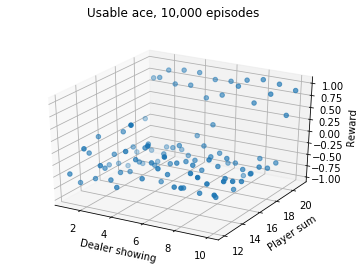

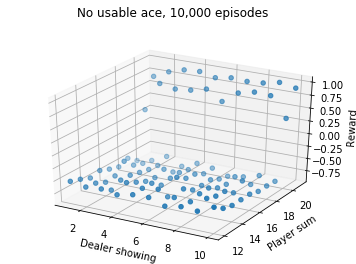

episode: 100000
episode: 200000
episode: 300000
episode: 400000
episode: 500000


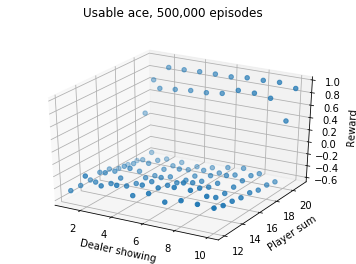

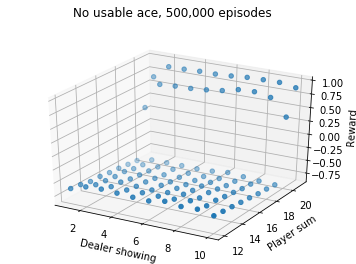

In [7]:
# Monte Carlo sampling to estimate Vπ(s) (On-Policy)
def monteCarloOnPolicy(nEpisodes):
    
    stateValueUsableAce = np.zeros((10, 10))
    stateValueUsableAceCount = np.ones((10, 10))  # initialze counts to 1 to avoid division by 0
    stateValueNoUsableAce = np.zeros((10, 10))
    stateValueNoUsableAceCount = np.ones((10, 10))  # initialze counts to 1 to avoid division by 0
    
    for episode in range(nEpisodes):
        if episode % 100000 == 100000-1:
            print('episode:', episode+1)
        
        state, reward, playerTrajectory = play(targetPolicyPlayer)
        playerTrajectory.insert(0, (None, state))
        for _, (playerSum, dealerCard, usableAce) in playerTrajectory:
            playerSum -= 12
            dealerCard -= 1
            if usableAce:
                stateValueUsableAceCount[playerSum, dealerCard] += 1
                stateValueUsableAce[playerSum, dealerCard] += reward
            else:
                stateValueNoUsableAceCount[playerSum, dealerCard] += 1
                stateValueNoUsableAce[playerSum, dealerCard] += reward
    return stateValueUsableAce / stateValueUsableAceCount, stateValueNoUsableAce / stateValueNoUsableAceCount

# Figure 5.1 Approximate state-value functions for the policy that sticks only on 20 or 21.
def onPolicy():
    stateValueUsableAce1, stateValueNoUsableAce1 = monteCarloOnPolicy(10000)
    prettyPrint(stateValueUsableAce1, 'Usable ace, 10,000 episodes')
    prettyPrint(stateValueNoUsableAce1, 'No usable ace, 10,000 episodes')
    plt.show()
    stateValueUsableAce2, stateValueNoUsableAce2 = monteCarloOnPolicy(500000)
    prettyPrint(stateValueUsableAce2, 'Usable ace, 500,000 episodes')
    prettyPrint(stateValueNoUsableAce2, 'No usable ace, 500,000 episodes')
    plt.show()

onPolicy()

States with a usable ace are less certain and less regular (because less common)

Although we have complete knowledge of the blackjack environment,<br>
MC has a significant advantage of using only sample episodes.

Also, estimates for each state are independent $\overrightarrow{}$ no *bootstrap*
- Computational cost of a single state is independent of the number of states
- Particularly efficient when only one or a subset of states is required

### 5.2 Monte Carlo Estimation of Action Values

If model is not available, it is useful to estimate *action* values **q<sub>\*</sub>** (rather than *state* values)

Estimating **q<sub>π</sub>(s, a)** is essentially same as for state values, except we visit *state-action* pair rather than state

We must maintain *exploration* by *exploring starts*
- episodes start in a state-action pair
- every pair has a nonzero probability of being selected

### 5.3 Monte Carlo Control

GPI:<br>
Value function repeatedly altered to more closely approximate for the current policy<br>
$\overrightarrow{}$ Policy repeatedly improved to the current value function $\overrightarrow{}$ **...**

Together, cause both policy and value function to approach optimality

![pic1](images/GPI.PNG)

![pic2](images/classical policy iteration.PNG)

MC can find optimal policies given only sample episodes, and no other knowledge of the environment's dynamics

Two unlikely assumptions:
1. Episodes have exploring starts
2. Infinite number of episodes

For MC, easy to avoid the infinite number of episodes<br>
by alternating between evaluation and improvement on every episode

### Monte Carlo Control with Exploring Starts

episode: 100000
episode: 200000
episode: 300000
episode: 400000
episode: 500000


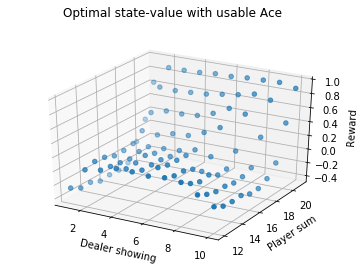

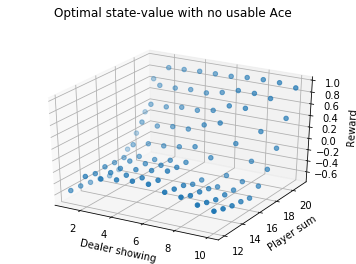

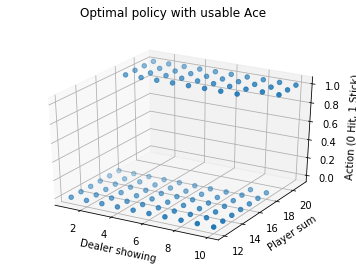

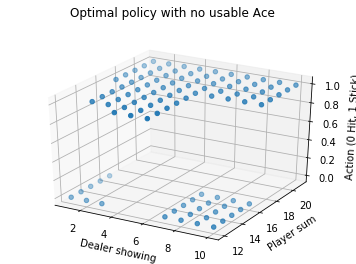

In [9]:
# Monte Carlo with Exploring Starts
def monteCarloES(nEpisodes):
    # (playerSum, dealerCard, usableAce, action)
    stateActionValues = np.zeros((10, 10, 2, 2))
    # initialze counts to 1 to avoid division by 0
    stateActionPairCount = np.ones((10, 10, 2, 2))
    
    # behavior policy is greedy
    def behaviorPolicy(playerSum, dealerCard, usableAce):
        playerSum -= 12
        dealerCard -= 1
        usableAce = int(usableAce)  # from bool
        # get argmax of the average returns(s, a)
        values_ = stateActionValues[playerSum, dealerCard, usableAce, :] / stateActionPairCount[playerSum, dealerCard, usableAce, :]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])
    
    # play for several episodes
    for episode in range(nEpisodes):
        if episode % 100000 == 100000-1:
            print('episode:', episode+1)
        # for each episode, use a randomly initialized state and action
        init_state = [np.random.choice(range(12, 22)),
                      np.random.choice(range(1, 11)),
                      bool(np.random.choice([0, 1]))]
        init_action = np.random.choice(actions)
        _, reward, trajectory = play(behaviorPolicy, init_state, init_action)
        
        for action, (playerSum, dealerCard, usableAce) in trajectory:
            playerSum -= 12
            dealerCard -= 1
            usableAce = int(usableAce)
            # update values of state-action pairs
            stateActionValues[playerSum, dealerCard, usableAce, action] += reward
            stateActionPairCount[playerSum, dealerCard, usableAce, action] += 1
    
    return stateActionValues / stateActionPairCount

# Figure 5.2 The state-value function and optimal policy found by Monte Carlo ES
def exploringStarts():
    stateActionValues = monteCarloES(500000)
    
    # State-value function
    stateValueUsableAce = np.zeros((10, 10))
    stateValueNoUsableAce = np.zeros((10, 10))
    
    # The optimal policy
    actionUsableAce = np.zeros((10, 10), dtype='int')
    actionNoUsableAce = np.zeros((10, 10), dtype='int')
    
    for i in range(10):
        for j in range(10):
            stateValueNoUsableAce[i, j] = np.max(stateActionValues[i, j, 0, :])
            stateValueUsableAce[i, j] = np.max(stateActionValues[i, j, 1, :])
            
            actionNoUsableAce[i, j] = np.argmax(stateActionValues[i, j, 0, :])
            actionUsableAce[i, j] = np.argmax(stateActionValues[i, j, 1, :])
    
    prettyPrint(stateValueUsableAce, 'Optimal state-value with usable Ace')
    prettyPrint(stateValueNoUsableAce, 'Optimal state-value with no usable Ace')
    prettyPrint(actionUsableAce, 'Optimal policy with usable Ace', 'Action (0 Hit, 1 Stick)')
    prettyPrint(actionNoUsableAce, 'Optimal policy with no usable Ace', 'Action (0 Hit, 1 Stick)')
    plt.show()

exploringStarts()

Compare with this [Blackjack Basic Strategy](http://www.chasingthefrog.com/reelfaces/21basicstrategy.php)

### Monte Carlo Sampling without Policy

runs: 20
runs: 40
runs: 60
runs: 80
runs: 100


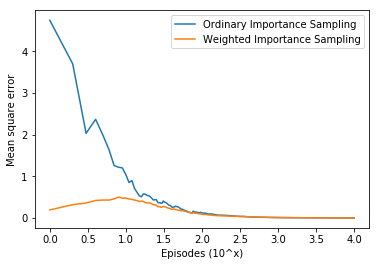

In [11]:
# Monte Carlo sampling with Off-Policy
def monteCarloOffPolicy(nEpisodes):
    init_state = [13, 2, True]
    sumOfImportanceRatio = [0]
    sumOfRewards = [0]
    
    for episode in range(nEpisodes):
        
        _, reward, playerTrajectory = play(behaviorPolicyPlayer, init_state=init_state)

        # get the importance ratio
        importanceRatioAbove = 1.0
        importanceRatioBelow = 1.0
        for action, (playerSum, dealerCard, usableAce) in playerTrajectory:
            if action == targetPolicyPlayer(playerSum, dealerCard, usableAce):
                importanceRatioBelow *= 0.5
            else:
                importanceRatioAbove = 0.0
                break
        importanceRatio = importanceRatioAbove / importanceRatioBelow
        sumOfImportanceRatio.append(sumOfImportanceRatio[-1] + importanceRatio)
        sumOfRewards.append(sumOfRewards[-1] + reward * importanceRatio)
    del sumOfImportanceRatio[0]
    del sumOfRewards[0]

    sumOfRewards= np.asarray(sumOfRewards)
    sumOfImportanceRatio= np.asarray(sumOfImportanceRatio)
    ordinarySampling = sumOfRewards / np.arange(1, nEpisodes + 1)

    with np.errstate(divide='ignore',invalid='ignore'):
        weightedSampling = np.where(sumOfImportanceRatio != 0, sumOfRewards / sumOfImportanceRatio, 0)

    return ordinarySampling, weightedSampling

# Figure 5.3 Weighted importance sampling produces lower error estimates
# of the value of a single state from off-policy episodes
def offPolicy():
    trueValue = -0.27726
    nEpisodes = 10000
    nRuns = 100
    ordinarySampling = np.zeros(nEpisodes)
    weightedSampling = np.zeros(nEpisodes)
    for runs in range(0, nRuns):
        if runs % 20 == 20-1:
            print('runs:', runs+1)
        
        ordinarySampling_, weightedSampling_ = monteCarloOffPolicy(nEpisodes)
        # get the squared error
        ordinarySampling += np.power(ordinarySampling_ - trueValue, 2)
        weightedSampling += np.power(weightedSampling_ - trueValue, 2)
    ordinarySampling /= nRuns
    weightedSampling /= nRuns
    axisX = np.log10(np.arange(1, nEpisodes + 1))
    plt.plot(axisX, ordinarySampling, label='Ordinary Importance Sampling')
    plt.plot(axisX, weightedSampling, label='Weighted Importance Sampling')
    plt.legend()
    plt.xlabel('Episodes (10^x)')
    plt.ylabel('Mean square error')
    plt.show()

offPolicy()